# SPM3D vs NMM3D Look-Up Table

This notebook mirrors the MATLAB comparison workflow for rough-surface backscatter.
It loads the NMM3D 40° NRCS look-up table, evaluates the SSRT SPM3D model for the
same parameter combinations, and plots/quantifies how closely the model tracks the
reference values.


In [4]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ssrt.surface.spm import SPM3D
from ssrt.utils.util import toLambda

NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_DIR = NOTEBOOK_ROOT / 'data'
if not DATA_DIR.exists():
    DATA_DIR = NOTEBOOK_ROOT.parent / 'data'

MPL_CACHE = NOTEBOOK_ROOT / '.mpl-cache'
MPL_CACHE.mkdir(exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(MPL_CACHE))

LUT_PATH = DATA_DIR / 'NMM3D_LUT_NRCS_40degree.dat'
if not LUT_PATH.exists():
    raise FileNotFoundError(f'NMM3D LUT not found at {LUT_PATH}')

FREQUENCY_GHZ = 5.405
INCIDENCE_DEG = 40.0
TARGET_RATIOS = []  # [] for all ratios, or provide values like [4, 10]
MARKERS = {i: marker for i, marker in enumerate(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x'])}
plt.style.use('seaborn-v0_8-whitegrid')


In [5]:
def load_lut(path):
    data = np.loadtxt(path)
    return {
        'theta': data[:, 0],
        'ratio': data[:, 1],
        'eps_real': data[:, 2],
        'eps_imag': data[:, 3],
        'rms_norm': data[:, 4],
        'vv_db': data[:, 5],
        'hh_db': data[:, 6],
        'hv_db': data[:, 7],
    }


def filter_by_incidence(lut, angle_deg, tol=1e-3):
    mask = np.abs(lut['theta'] - angle_deg) <= tol
    if not np.any(mask):
        raise ValueError(f'No entries found at {angle_deg} degrees in LUT')
    return {key: val[mask] for key, val in lut.items()}


def compute_metrics(sim, ref):
    mask = np.isfinite(sim) & np.isfinite(ref)
    if not np.any(mask):
        return {'r': np.nan, 'rmse': np.nan, 'bias': np.nan, 'mae': np.nan, 'n': 0}
    sim = sim[mask]
    ref = ref[mask]
    diff = sim - ref
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    r = float(np.corrcoef(ref, sim)[0, 1]) if sim.size > 1 else np.nan
    return {'r': r, 'rmse': rmse, 'bias': bias, 'mae': mae, 'n': int(sim.size)}


In [6]:
lut = load_lut(LUT_PATH)
subset = filter_by_incidence(lut, INCIDENCE_DEG)

ratios_all = np.unique(subset['ratio'])
if TARGET_RATIOS:
    target = np.array(TARGET_RATIOS, dtype=float)
    mask = np.isin(subset['ratio'], target)
    subset = {k: v[mask] for k, v in subset.items()}
    ratios_used = np.unique(subset['ratio'])
else:
    ratios_used = ratios_all

if subset['ratio'].size == 0:
    raise ValueError('No LUT entries left after ratio filtering.')

print(f'Ratios in use: {np.array2string(ratios_used, precision=2)}')

group_results = []
reference_rows = defaultdict(list)

lambda_m = toLambda(FREQUENCY_GHZ)

unique_groups = np.unique(
    np.vstack([
        subset['ratio'],
        subset['eps_real'],
        subset['eps_imag']
    ]).T,
    axis=0
)

for ratio, eps_r, eps_i in unique_groups:
    mask = (
        np.isclose(subset['ratio'], ratio)
        & np.isclose(subset['eps_real'], eps_r)
        & np.isclose(subset['eps_imag'], eps_i)
    )
    if not np.any(mask):
        continue
    idx = np.argsort(subset['rms_norm'][mask])
    rms_norm = subset['rms_norm'][mask][idx]
    vv_ref = subset['vv_db'][mask][idx]
    hh_ref = subset['hh_db'][mask][idx]
    hv_ref = subset['hv_db'][mask][idx]

    sigma = rms_norm * lambda_m
    corr_length = ratio * sigma

    model = SPM3D(
        fr=FREQUENCY_GHZ,
        sig=sigma,
        L=corr_length,
        thi=INCIDENCE_DEG,
        er=complex(eps_r, eps_i)
    )
    vv_spm, hh_spm, hv_spm, _ = model.calc_sigma()

    group_results.append({
        'ratio': ratio,
        'eps_real': eps_r,
        'eps_imag': eps_i,
        'ks': 2 * np.pi * rms_norm,
        'vv_ref': vv_ref,
        'hh_ref': hh_ref,
        'hv_ref': hv_ref,
        'vv_spm': vv_spm,
        'hh_spm': hh_spm,
        'hv_spm': hv_spm,
    })

    reference_rows['vv_ref'].append(vv_ref)
    reference_rows['hh_ref'].append(hh_ref)
    reference_rows['hv_ref'].append(hv_ref)
    reference_rows['vv_spm'].append(vv_spm)
    reference_rows['hh_spm'].append(hh_spm)
    reference_rows['hv_spm'].append(hv_spm)

print(f'Groups compared: {len(group_results)}')


Ratios in use: [ 4.  7. 10. 15.]
Groups compared: 24


/tmp/ipykernel_93362/1361770229.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


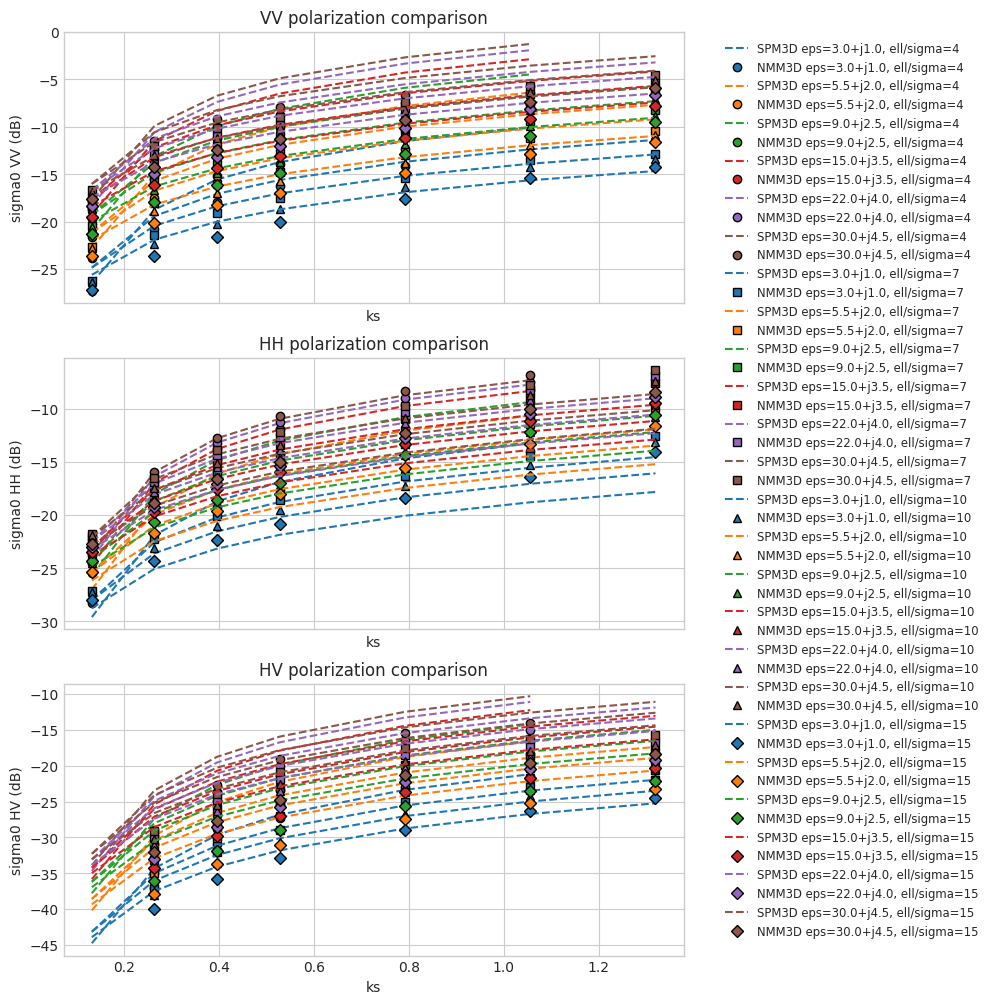

In [19]:
if not group_results:
    raise RuntimeError('No group comparisons available for plotting.')

unique_dielectrics = sorted({(g['eps_real'], g['eps_imag']) for g in group_results})
color_map = {die: plt.cm.tab10(i % 10) for i, die in enumerate(unique_dielectrics)}
ratios_sorted = sorted({g['ratio'] for g in group_results})
marker_map = {ratio: MARKERS[i % len(MARKERS)] for i, ratio in enumerate(ratios_sorted)}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
bands = [('vv', 'sigma0 VV (dB)'), ('hh', 'sigma0 HH (dB)'), ('hv', 'sigma0 HV (dB)')]

for ax, (band_key, ylabel) in zip(axes, bands):
    plotted_labels = set()
    for group in group_results:
        ratio = group['ratio']
        eps_pair = (group['eps_real'], group['eps_imag'])
        color = color_map[eps_pair]
        marker = marker_map[ratio]
        ks = group['ks']

        spm_vals = group[f'{band_key}_spm']
        ref_vals = group[f'{band_key}_ref']

        label_spm = f'SPM3D eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}, ell/sigma={ratio:g}'
        if label_spm not in plotted_labels:
            ax.plot(ks, spm_vals, linestyle='--', color=color, label=label_spm)
            plotted_labels.add(label_spm)
        else:
            ax.plot(ks, spm_vals, linestyle='--', color=color)

        finite_mask = np.isfinite(ref_vals)
        if np.any(finite_mask):
            label_ref = f'NMM3D eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}, ell/sigma={ratio:g}'
            if label_ref not in plotted_labels:
                ax.plot(
                    ks[finite_mask],
                    ref_vals[finite_mask],
                    linestyle='none',
                    marker=marker,
                    markersize=6,
                    markerfacecolor=color,
                    markeredgecolor='black',
                    label=label_ref
                )
                plotted_labels.add(label_ref)
            else:
                ax.plot(
                    ks[finite_mask],
                    ref_vals[finite_mask],
                    linestyle='none',
                    marker=marker,
                    markersize=6,
                    markerfacecolor=color,
                    markeredgecolor='black'
                )

    ax.set_xlabel('ks')
    ax.set_ylabel(ylabel)
    ax.grid(True)

axes[0].set_title('VV polarization comparison')
axes[1].set_title('HH polarization comparison')
axes[2].set_title('HV polarization comparison')

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()


In [8]:
metrics_rows = []
for band, label in [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]:
    ref_list = reference_rows[f'{band}_ref']
    sim_list = reference_rows[f'{band}_spm']
    if not ref_list:
        metrics_rows.append({'Band': label, 'Samples': 0, 'RMSE (dB)': np.nan, 'Bias (dB)': np.nan, 'MAE (dB)': np.nan, 'Correlation r': np.nan})
        continue
    ref = np.concatenate(ref_list)
    sim = np.concatenate(sim_list)
    stats = compute_metrics(sim, ref)
    metrics_rows.append({
        'Band': label,
        'Samples': stats['n'],
        'RMSE (dB)': stats['rmse'],
        'Bias (dB)': stats['bias'],
        'MAE (dB)': stats['mae'],
        'Correlation r': stats['r'],
    })

metrics_df = pd.DataFrame(metrics_rows).set_index('Band')
metrics_df


,Samples,RMSE (dB),Bias (dB),MAE (dB),Correlation r
Band,,,,,
VV,162,2.147917,1.896931,1.904968,0.983690
HH,162,1.369072,-0.975561,1.020901,0.983763
HV,138,3.723580,3.397494,3.468048,0.966648
